# Import and Initialize

In [10]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
from fuzzywuzzy import fuzz

file_path = '/Users/peterwilliams/Downloads/PlaneCrashes/PlaneCrashes.csv'

df = pd.read_csv(file_path)
df = pd.DataFrame(df)

# Cleaning

In [12]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.columns = pd.Series(df.columns).apply(lambda col: col.lower())
df.dropna(how='all', inplace= True)
df.fillna("unknown", inplace = True)
df.columns = df.columns.str.replace(' ', '_')
df['crew_on_board'] = df['crew_on_board'].replace('unknown', '0.0')
df['crew_on_board'] = pd.to_numeric(df['crew_on_board'], errors='coerce')

df['pax_on_board'] = df['pax_on_board'].replace('unknown', '0.0')
df['pax_on_board'] = pd.to_numeric(df['pax_on_board'], errors='coerce')

df['crew_fatalities'] = df['crew_fatalities'].replace('unknown', '0.0')
df['crew_fatalities'] = pd.to_numeric(df['crew_fatalities'], errors='coerce')

df['pax_fatalities'] = df['pax_fatalities'].replace('unknown', '0.0')
df['pax_fatalities'] = pd.to_numeric(df['pax_fatalities'], errors='coerce')

df['other_fatalities'] = df['other_fatalities'].replace('unknown', '0.0')
df['other_fatalities'] = pd.to_numeric(df['other_fatalities'], errors='coerce')

df['total_on_board'] = df['crew_on_board'] + df['pax_on_board']
df['total_fatalities'] = df['crew_fatalities'] + df['pax_fatalities'] + df['other_fatalities']

df_cleaned = df.drop(['crew_on_board', 'crew_fatalities', 'pax_on_board', 'pax_fatalities', 'other_fatalities'], axis=1)

df.drop(['msn',
         'yom',
         'flight_no.', 
        ], axis=1, inplace=True)

order = [
    "date", "time", "aircraft", "operator", "flight_phase",
    "flight_type", "crash_site", "schedule", "crash_location",
    "country", "region", "circumstances", "crash_cause",
    "total_on_board", "total_fatalities", "survivors"
]

df_cleaned = df_cleaned[order]

In [13]:
passenger_types = [
    "scheduled revenue flight",
    "charter/taxi (non scheduled revenue flight)",
    "private",
    "executive/corporate/business",
    "ferry"
    "cargo",
    "positioning",
    "ambulance",
    "topographic",
    "geographical / geophysical / scientific",
    "illegal (smuggling)",
    "spraying (agricultural)",
    "humanitarian",
    "meteorological / weather",
    "fire fighting"
]

df_cleaned['flight_type'] = df_cleaned['flight_type'].apply(lambda x: 'passenger flights' if x in passenger_types else None)

df_cleaned = df_cleaned.dropna(subset=['flight_type']) 

# Fatal Routes

In [15]:
df_routes = df_cleaned.sort_values(by='schedule', ascending=False)

print(df_cleaned)

             date        time                              aircraft  \
31     1919-03-23     unknown                      unnamed aircraft   
32     1919-04-07     unknown                      unnamed aircraft   
45     1919-05-19   12h 0m 0s                   farman f.60 goliath   
49     1919-05-31     unknown              blackburn r.t.1 kangaroo   
51     1919-06-15   8h 40m 0s         vickers fb.27 vimy commercial   
...           ...         ...                                   ...   
28529  2022-05-11     unknown         de havilland dhc-6 twin otter   
28530  2022-05-12    8h 4m 0s                           airbus a319   
28532  2022-05-23  18h 29m 0s  piper pa-61 aerostar (ted smith 601)   
28533  2022-05-24  15h 40m 0s              de havilland dhc-3 otter   
28534  2022-05-29   10h 7m 0s         de havilland dhc-6 twin otter   

                       operator                   flight_phase  \
31               private french                         flight   
32             

In [16]:
df_routes = df_cleaned.groupby("schedule")[["total_fatalities"]].sum().sort_values(by="total_fatalities", ascending=False).head(21)
df_routes = df_routes.iloc[1:]
df_routes

,total_fatalities
schedule,
tokyo - osaka,520.0
ankara - paris - london,346.0
los angeles – new york – las palmas,335.0
vancouver – toronto – montreal – london – new delhi – bombay,329.0
new delhi - dhahran - jeddah,312.0
karachi - riyadh - jeddah,301.0
amsterdam – kuala lumpur,298.0
bandar abbas – dubai,290.0
karachi - islamabad,279.0


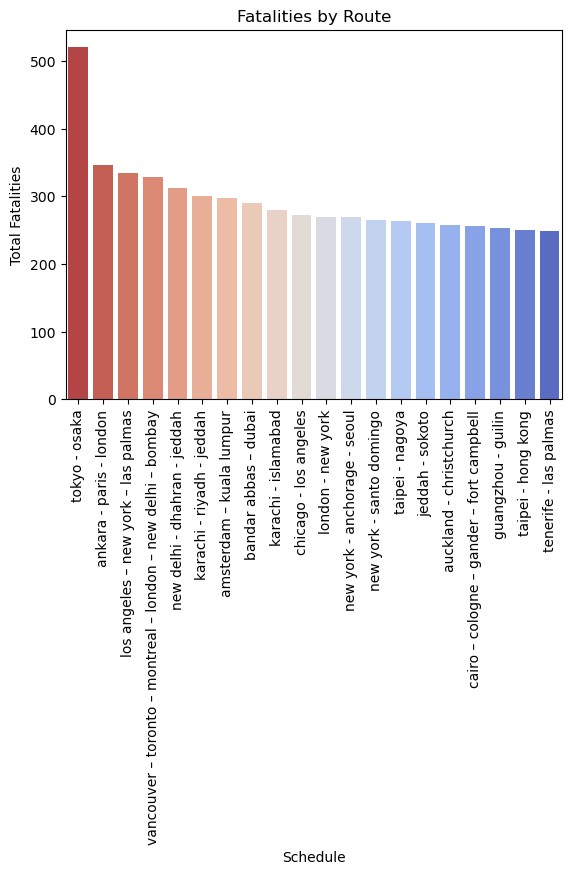

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x="schedule",y = "total_fatalities", data=df_routes, palette="coolwarm_r")
plt.title("Fatalities by Route")
plt.xticks(rotation=90)
plt.xlabel("Schedule")
plt.ylabel("Total Fatalities")
df_routes_reversed = df_routes.iloc[::-1]

In [18]:
df_routes["total_fatalities"].mean()

293.8

In [19]:
df_routes.mean()

total_fatalities    293.8
dtype: float64

In [20]:
df_routes.describe()

,total_fatalities
count,20.000000
mean,293.800000
std,60.841987
min,248.000000
25%,260.000000
50%,271.500000
75%,303.750000
max,520.000000


In [21]:
df_routes.sum()

total_fatalities    5876.0
dtype: float64

# Distance of Crash from Airport

In [23]:
df_cleaned.keys()

Index(['date', 'time', 'aircraft', 'operator', 'flight_phase', 'flight_type',
       'crash_site', 'schedule', 'crash_location', 'country', 'region',
       'circumstances', 'crash_cause', 'total_on_board', 'total_fatalities',
       'survivors'],
      dtype='object')

In [24]:
df_cleaned

,date,time,aircraft,operator,flight_phase,flight_type,crash_site,schedule,crash_location,country,region,circumstances,crash_cause,total_on_board,total_fatalities,survivors
31,1919-03-23,unknown,unnamed aircraft,private french,flight,passenger flights,"plain, valley",unknown,bordeaux gironde,france,europe,"in flight, the crew encountered engine problem...",technical failure,2.0,0.0,yes
32,1919-04-07,unknown,unnamed aircraft,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,france all france,france,europe,crashed in unknow circumstances somewhere in f...,technical failure,0.0,0.0,yes
45,1919-05-19,12h 0m 0s,farman f.60 goliath,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,belgium all belgium,belgium,europe,unknown,unknown,0.0,0.0,unknown
49,1919-05-31,unknown,blackburn r.t.1 kangaroo,grahame-white aviation,takeoff (climb),passenger flights,airport (less than 10 km from airport),unknown,hendon middlesex,united kingdom,europe,"shortly after takeoff, during initial climb, t...",technical failure,3.0,0.0,yes
51,1919-06-15,8h 40m 0s,vickers fb.27 vimy commercial,vickers-armstrongs ltd,landing (descent or approach),passenger flights,"plain, valley",saint john's - clifden,clifden connacht,ireland,europe,british aviators john alcock and arthur whitte...,unknown,2.0,0.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,2022-05-11,unknown,de havilland dhc-6 twin otter,caverton helicopters,flight,passenger flights,"plain, valley",yaoundé – dompta – belabo,nanga eboko centre,cameroon,africa,the twin engine airplane departed yaoundé at 1...,unknown,11.0,11.0,no
28530,2022-05-12,8h 4m 0s,airbus a319,tibet airlines,takeoff (climb),passenger flights,airport (less than 10 km from airport),chongqing – nyingchi,chongqing-jiangbei sichuan,china,asia,the airplane was departing chongqing-jiangbei ...,unknown,122.0,0.0,yes
28532,2022-05-23,18h 29m 0s,piper pa-61 aerostar (ted smith 601),raul ignacion posada,flight,passenger flights,"plain, valley",celaya - durango,durango durango,mexico,central america,while approaching durango airport on a flight ...,unknown,2.0,2.0,no
28533,2022-05-24,15h 40m 0s,de havilland dhc-3 otter,yakutat coastal airlines,landing (descent or approach),passenger flights,airport (less than 10 km from airport),yakutat – dry bay,dry bay alaska,united states of america,north america,the single engine airplane departed yakutat on...,unknown,4.0,0.0,yes


In [25]:
df_cleaned["crash_site"].unique()

array(['plain, valley', 'airport (less than 10 km from airport)',
       'unknown', 'lake, sea, ocean, river', 'desert', 'mountains',
       'city'], dtype=object)

In [26]:
df_cleaned.sort_values(by="crash_site", ascending=False)
df_cleaned

,date,time,aircraft,operator,flight_phase,flight_type,crash_site,schedule,crash_location,country,region,circumstances,crash_cause,total_on_board,total_fatalities,survivors
31,1919-03-23,unknown,unnamed aircraft,private french,flight,passenger flights,"plain, valley",unknown,bordeaux gironde,france,europe,"in flight, the crew encountered engine problem...",technical failure,2.0,0.0,yes
32,1919-04-07,unknown,unnamed aircraft,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,france all france,france,europe,crashed in unknow circumstances somewhere in f...,technical failure,0.0,0.0,yes
45,1919-05-19,12h 0m 0s,farman f.60 goliath,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,belgium all belgium,belgium,europe,unknown,unknown,0.0,0.0,unknown
49,1919-05-31,unknown,blackburn r.t.1 kangaroo,grahame-white aviation,takeoff (climb),passenger flights,airport (less than 10 km from airport),unknown,hendon middlesex,united kingdom,europe,"shortly after takeoff, during initial climb, t...",technical failure,3.0,0.0,yes
51,1919-06-15,8h 40m 0s,vickers fb.27 vimy commercial,vickers-armstrongs ltd,landing (descent or approach),passenger flights,"plain, valley",saint john's - clifden,clifden connacht,ireland,europe,british aviators john alcock and arthur whitte...,unknown,2.0,0.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,2022-05-11,unknown,de havilland dhc-6 twin otter,caverton helicopters,flight,passenger flights,"plain, valley",yaoundé – dompta – belabo,nanga eboko centre,cameroon,africa,the twin engine airplane departed yaoundé at 1...,unknown,11.0,11.0,no
28530,2022-05-12,8h 4m 0s,airbus a319,tibet airlines,takeoff (climb),passenger flights,airport (less than 10 km from airport),chongqing – nyingchi,chongqing-jiangbei sichuan,china,asia,the airplane was departing chongqing-jiangbei ...,unknown,122.0,0.0,yes
28532,2022-05-23,18h 29m 0s,piper pa-61 aerostar (ted smith 601),raul ignacion posada,flight,passenger flights,"plain, valley",celaya - durango,durango durango,mexico,central america,while approaching durango airport on a flight ...,unknown,2.0,2.0,no
28533,2022-05-24,15h 40m 0s,de havilland dhc-3 otter,yakutat coastal airlines,landing (descent or approach),passenger flights,airport (less than 10 km from airport),yakutat – dry bay,dry bay alaska,united states of america,north america,the single engine airplane departed yakutat on...,unknown,4.0,0.0,yes


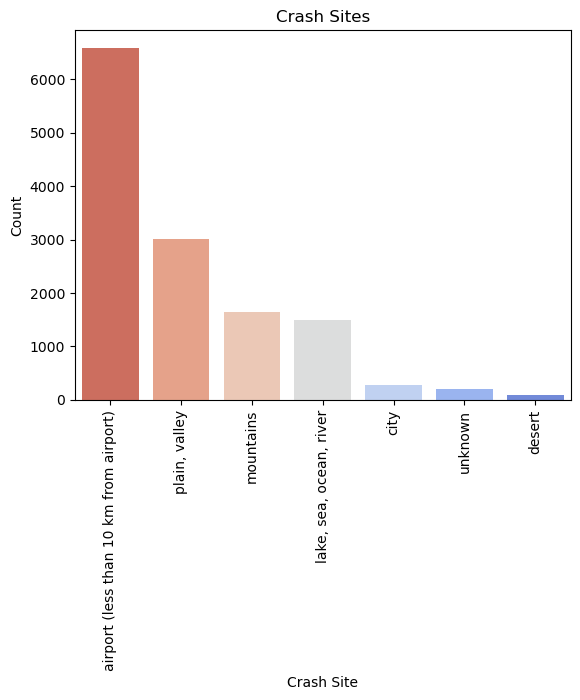

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences and sort in descending order
sorted_data = df_cleaned["crash_site"].value_counts()

# Convert the Series to a DataFrame
sorted_df = sorted_data.reset_index()
sorted_df.columns = ["crash_site", "count"]  # Rename columns for clarity

# Plot using the sorted data
sns.barplot(x="crash_site", y="count", data=sorted_df, palette="coolwarm_r")
plt.title("Crash Sites")
plt.xticks(rotation=90)
plt.xlabel("Crash Site")
plt.ylabel("Count")
plt.show()

In [28]:
df_cleaned["crash_site"].unique()

array(['plain, valley', 'airport (less than 10 km from airport)',
       'unknown', 'lake, sea, ocean, river', 'desert', 'mountains',
       'city'], dtype=object)

In [29]:
df_cleaned["flight_phase"].value_counts()

flight_phase
landing (descent or approach)    5387
flight                           4389
takeoff (climb)                  2997
unknown                           365
taxiing                            98
parking                            59
Name: count, dtype: int64

# Bird Strike

In [32]:
df_cleaned.keys()

Index(['date', 'time', 'aircraft', 'operator', 'flight_phase', 'flight_type',
       'crash_site', 'schedule', 'crash_location', 'country', 'region',
       'circumstances', 'crash_cause', 'total_on_board', 'total_fatalities',
       'survivors'],
      dtype='object')

In [33]:
def circs(value):
        if 'bird' in value.lower():
            return 'bird'
        elif 'strike' in value.lower():
            return 'bird'
        else:
            return 'none'

In [34]:
df_cleaned["Cause"]=df_cleaned["circumstances"].apply(circs)

In [37]:
df_cleaned['Cause'].unique()

array(['none', 'bird'], dtype=object)

In [38]:
df_cleaned['Cause'].value_counts()

Cause
none    13173
bird      122
Name: count, dtype: int64

Text(0, 0.5, 'Count of Type')

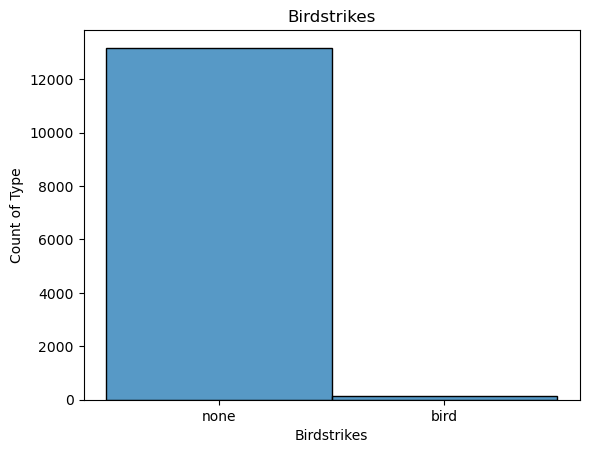

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_cleaned['Cause'], bins=100)
plt.title("Birdstrikes")
plt.xlabel("Birdstrikes")
plt.ylabel("Count of Type")

In [42]:
df_loc_phase= df_cleaned[
    (df_cleaned["crash_site"].isin(["airport (less than 10 km from airport)"])) &
    (df_cleaned["flight_phase"].isin(["landing (descent or approach)","takeoff (climb)"]))
]
print(df_loc_phase)

             date        time                      aircraft  \
49     1919-05-31     unknown      blackburn r.t.1 kangaroo   
63     1919-08-06     unknown                      avro 536   
73     1919-08-30     unknown                      avro 536   
82     1919-10-02   8h 45m 0s             de havilland dh.4   
101    1919-12-09     unknown                      avro 536   
...           ...         ...                           ...   
28507  2022-02-15     unknown       britten-norman islander   
28517  2022-04-02  11h 19m 0s                    learjet 75   
28526  2022-05-06  14h 18m 0s  cessna 421c golden eagle iii   
28530  2022-05-12    8h 4m 0s                   airbus a319   
28533  2022-05-24  15h 40m 0s      de havilland dhc-3 otter   

                                     operator                   flight_phase  \
49                     grahame-white aviation                takeoff (climb)   
63                         avro air transport  landing (descent or approach)   
73 

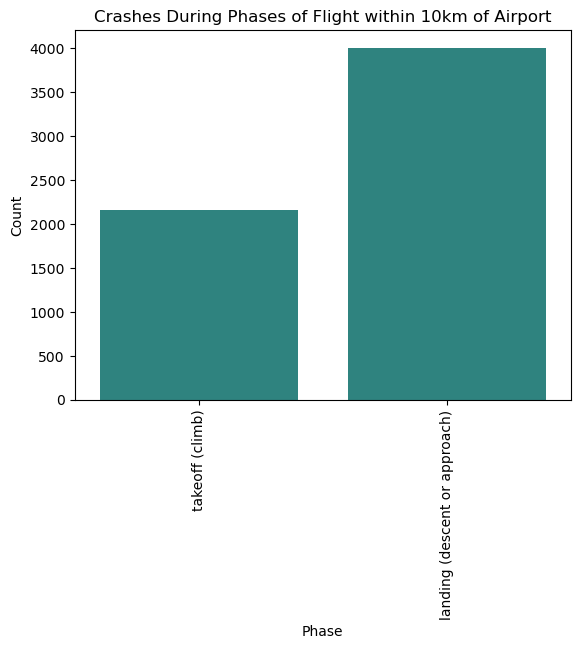

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="flight_phase", hue="crash_site", data=df_loc_phase, palette="viridis")
plt.title("Crashes During Phases of Flight within 10km of Airport")
plt.xlabel("Phase")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend().remove()  # Correct way to remove the legend
plt.show()

In [53]:
df = df_loc_phase["flight_phase"].value_counts()
print(df)

flight_phase
landing (descent or approach)    4010
takeoff (climb)                  2163
Name: count, dtype: int64


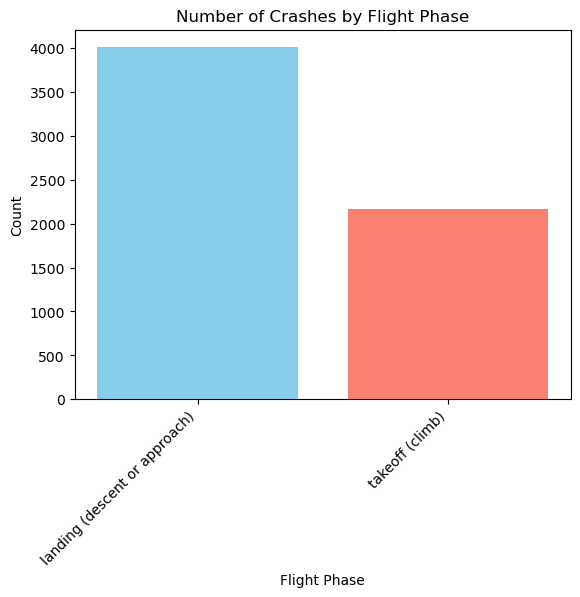

In [68]:
df = df_loc_phase["flight_phase"].value_counts()
plt.bar(df.index, df.values, color=["skyblue", "salmon"])
plt.title("Number of Crashes by Flight Phase")
plt.xlabel("Flight Phase")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Adjust for better readability
plt.show()

# Aircraft Lengths not finished

In [142]:
df_aircrafts = pd.read_excel('/Users/peterwilliams/Downloads/aircraft_data.xlsx')
df_aircrafts = pd.DataFrame(df_aircrafts)

df_aircrafts = df_aircrafts.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df_aircrafts.columns = pd.Series(df_aircrafts.columns).apply(lambda col: col.lower())
df_aircrafts.dropna(how='all', inplace= True)

/Users/peterwilliams/Anaconda3/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/peterwilliams/Anaconda3/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


In [143]:
df_aircrafts= df_aircrafts.head(50)
df_aircrafts

,icao_code,faa_designator,manufacturer,model_faa,model_bada,physical_class_engine,num_engines,aac,aac_minimum,aac_maximum,adg,tdg,approach_speed_knot,approach_speed_minimum_knot,approach_speed_maximum_knot,wingspan_ft_without_winglets_sharklets,wingspan_ft_with_winglets_sharklets,length_ft,tail_height_at_oew_ft,wheelbase_ft,cockpit_to_main_gear_ft,main_gear_width_ft,mtow_lb,malw_lb,main_gear_config,icao_wtc,parking_area_ft2,class,faa_weight,cwt,one_half_wake_category,two_wake_category_appx_a,two_wake_category_appx_b,rotor_diameter_ft,srs,lahso,faa_registry,registration_count,tmfs_operations_fy24,remarks,lastupdate,unnamed: 41,unnamed: 42,unnamed: 43,unnamed: 44,unnamed: 45,unnamed: 46,unnamed: 47,unnamed: 48,unnamed: 49,unnamed: 50,unnamed: 51,unnamed: 52,unnamed: 53,unnamed: 54,unnamed: 55
0,a10,a10,fairchild,fairchild a10,fairchild a-10a,jet,2,c,NaN,NaN,ii,2a,140.0,NaN,NaN,57.5,NaN,53.30,14.70,17.90,17.9,18.30,50044.934,NaN,s,medium,3935.3,fixed-wing,large,g,e,d,d,NaN,iii,NaN,yes,281.0,12844,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a124,a124,antonov,antonov an-124 ruslan,antonov an-124-100,jet,4,d,NaN,NaN,vi,5,151.0,NaN,NaN,240.5,NaN,226.20,68.20,78.90,92.0,33.00,892871.000,727525.0,5d,heavy,57915.6,fixed-wing,heavy,d,b,g,g,NaN,iii,NaN,yes,55.0,506,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a19n,a19n,airbus,airbus a319 neo,airbus a319 neo,jet,2,c,NaN,NaN,iii,3,130.0,NaN,NaN,NaN,117.50,111.00,39.70,36.20,44.9,29.40,166449.000,137789.0,d,medium,14790.0,fixed-wing,large,f,d,d,c,NaN,iii,7.0,no,0.0,166,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a20n,a20n,airbus,airbus a320 neo,airbus a320-271n,jet,2,c,NaN,NaN,iii,3,137.0,NaN,NaN,NaN,117.50,123.30,39.60,41.50,50.2,29.40,174165.000,148591.0,d,medium,16358.3,fixed-wing,large,f,d,d,c,NaN,iii,7.0,yes,147.0,540276,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a21n,a21n,airbus,airbus a321 neo,airbus a321-251n,jet,2,c,NaN,NaN,iii,3,136.0,NaN,NaN,NaN,117.50,146.00,39.70,55.50,64.2,29.40,209439.000,174606.0,d,medium,19253.0,fixed-wing,large,f,d,d,c,NaN,iii,7.0,yes,106.0,307984,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,a306,a306,airbus,airbus a300 b4-600,airbus a300b4-622,jet,2,c,NaN,NaN,iv,5,137.0,NaN,NaN,147.1,NaN,177.40,54.70,61.00,75.0,36.00,363760.000,304230.0,2d,heavy,28666.7,fixed-wing,heavy,c,c,c,b,NaN,iii,7.0,yes,29.0,138268,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,a30b,a30b,airbus,airbus a300-b2,airbus a300b4-203,jet,2,c,NaN,NaN,iv,5,137.0,NaN,NaN,147.1,NaN,175.50,54.90,60.80,75.0,36.10,363760.000,299829.0,2d,heavy,28352.9,fixed-wing,heavy,c,c,c,b,NaN,iii,8.0,yes,3.0,12,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,a310,a310,airbus,airbus a310,airbus a310-204,jet,2,c,NaN,NaN,iv,5,139.0,NaN,NaN,144.0,NaN,153.20,52.30,49.90,63.9,36.00,317465.000,273372.0,2d,heavy,24361.0,fixed-wing,heavy,c,c,c,b,NaN,iii,7.0,yes,26.0,358,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a318,a318,airbus,airbus a318,airbus a318-112,jet,2,c,NaN,NaN,iii,3,121.0,NaN,NaN,111.9,NaN,103.20,42.30,33.60,42.4,29.40,149914.000,126766.0,d,medium,13185.0,fixed-wing,large,f,d,d,c,NaN,iii,7.0,yes,7.0,48,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,a319,a319,airbus,airbus a319,airbus a319-131,jet,2,c,NaN,NaN,iii,3,126.0,NaN,NaN,111.9,117.50,111.00,39.70,36.20,44.9,29.40,168653.000,134482.0,d,medium,14140.5,fixed-wing,large,f,d,d,c,NaN,iii,7.0,yes,413.0,915976,aac validated by flight standardization board ...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
df_aircrafts = df_aircrafts[["model_faa","length_ft", "class"]]

In [145]:
df_aircrafts

,model_faa,length_ft,class
0,fairchild a10,53.30,fixed-wing
1,antonov an-124 ruslan,226.20,fixed-wing
2,airbus a319 neo,111.00,fixed-wing
3,airbus a320 neo,123.30,fixed-wing
4,airbus a321 neo,146.00,fixed-wing
5,airbus a300 b4-600,177.40,fixed-wing
6,airbus a300-b2,175.50,fixed-wing
7,airbus a310,153.20,fixed-wing
8,airbus a318,103.20,fixed-wing
9,airbus a319,111.00,fixed-wing


In [146]:
from fuzzywuzzy import process

In [147]:
def get_best_match_rapidfuzz(aircraft_name, choices, threshold=95):
    best_match = process.extractOne(aircraft_name, choices)
    return best_match[0] if best_match else None

df_cleaned['model_faa'] = df_cleaned['aircraft'].apply(lambda x: get_best_match_rapidfuzz(x, standard_aircraft_names))

In [148]:
df_cleaned

,date,time,aircraft,operator,flight_phase,flight_type,crash_site,schedule,crash_location,country,region,circumstances,crash_cause,total_on_board,total_fatalities,survivors,Cause,model_faa
31,1919-03-23,unknown,unnamed aircraft,private french,flight,passenger flights,"plain, valley",unknown,bordeaux gironde,france,europe,"in flight, the crew encountered engine problem...",technical failure,2.0,0.0,yes,none,at-602 air tractor
32,1919-04-07,unknown,unnamed aircraft,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,france all france,france,europe,crashed in unknow circumstances somewhere in f...,technical failure,0.0,0.0,yes,none,at-602 air tractor
45,1919-05-19,12h 0m 0s,farman f.60 goliath,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,belgium all belgium,belgium,europe,unknown,unknown,0.0,0.0,unknown,none,atr 42-600
49,1919-05-31,unknown,blackburn r.t.1 kangaroo,grahame-white aviation,takeoff (climb),passenger flights,airport (less than 10 km from airport),unknown,hendon middlesex,united kingdom,europe,"shortly after takeoff, during initial climb, t...",technical failure,3.0,0.0,yes,none,antonov an-124 ruslan
51,1919-06-15,8h 40m 0s,vickers fb.27 vimy commercial,vickers-armstrongs ltd,landing (descent or approach),passenger flights,"plain, valley",saint john's - clifden,clifden connacht,ireland,europe,british aviators john alcock and arthur whitte...,unknown,2.0,0.0,yes,none,rockwell commander 112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,2022-05-11,unknown,de havilland dhc-6 twin otter,caverton helicopters,flight,passenger flights,"plain, valley",yaoundé – dompta – belabo,nanga eboko centre,cameroon,africa,the twin engine airplane departed yaoundé at 1...,unknown,11.0,11.0,no,none,at-602 air tractor
28530,2022-05-12,8h 4m 0s,airbus a319,tibet airlines,takeoff (climb),passenger flights,airport (less than 10 km from airport),chongqing – nyingchi,chongqing-jiangbei sichuan,china,asia,the airplane was departing chongqing-jiangbei ...,unknown,122.0,0.0,yes,none,airbus a319
28532,2022-05-23,18h 29m 0s,piper pa-61 aerostar (ted smith 601),raul ignacion posada,flight,passenger flights,"plain, valley",celaya - durango,durango durango,mexico,central america,while approaching durango airport on a flight ...,unknown,2.0,2.0,no,none,piper aero star
28533,2022-05-24,15h 40m 0s,de havilland dhc-3 otter,yakutat coastal airlines,landing (descent or approach),passenger flights,airport (less than 10 km from airport),yakutat – dry bay,dry bay alaska,united states of america,north america,the single engine airplane departed yakutat on...,unknown,4.0,0.0,yes,none,aero commander 500


# Crashes by country

In [176]:
df_cleaned.sort_values(by="country", ascending=False)
df_cleaned

,date,time,aircraft,operator,flight_phase,flight_type,crash_site,schedule,crash_location,country,region,circumstances,crash_cause,total_on_board,total_fatalities,survivors,Cause,model_faa
31,1919-03-23,unknown,unnamed aircraft,private french,flight,passenger flights,"plain, valley",unknown,bordeaux gironde,france,europe,"in flight, the crew encountered engine problem...",technical failure,2.0,0.0,yes,none,at-602 air tractor
32,1919-04-07,unknown,unnamed aircraft,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,france all france,france,europe,crashed in unknow circumstances somewhere in f...,technical failure,0.0,0.0,yes,none,at-602 air tractor
45,1919-05-19,12h 0m 0s,farman f.60 goliath,private french,landing (descent or approach),passenger flights,"plain, valley",unknown,belgium all belgium,belgium,europe,unknown,unknown,0.0,0.0,unknown,none,atr 42-600
49,1919-05-31,unknown,blackburn r.t.1 kangaroo,grahame-white aviation,takeoff (climb),passenger flights,airport (less than 10 km from airport),unknown,hendon middlesex,united kingdom,europe,"shortly after takeoff, during initial climb, t...",technical failure,3.0,0.0,yes,none,antonov an-124 ruslan
51,1919-06-15,8h 40m 0s,vickers fb.27 vimy commercial,vickers-armstrongs ltd,landing (descent or approach),passenger flights,"plain, valley",saint john's - clifden,clifden connacht,ireland,europe,british aviators john alcock and arthur whitte...,unknown,2.0,0.0,yes,none,rockwell commander 112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,2022-05-11,unknown,de havilland dhc-6 twin otter,caverton helicopters,flight,passenger flights,"plain, valley",yaoundé – dompta – belabo,nanga eboko centre,cameroon,africa,the twin engine airplane departed yaoundé at 1...,unknown,11.0,11.0,no,none,at-602 air tractor
28530,2022-05-12,8h 4m 0s,airbus a319,tibet airlines,takeoff (climb),passenger flights,airport (less than 10 km from airport),chongqing – nyingchi,chongqing-jiangbei sichuan,china,asia,the airplane was departing chongqing-jiangbei ...,unknown,122.0,0.0,yes,none,airbus a319
28532,2022-05-23,18h 29m 0s,piper pa-61 aerostar (ted smith 601),raul ignacion posada,flight,passenger flights,"plain, valley",celaya - durango,durango durango,mexico,central america,while approaching durango airport on a flight ...,unknown,2.0,2.0,no,none,piper aero star
28533,2022-05-24,15h 40m 0s,de havilland dhc-3 otter,yakutat coastal airlines,landing (descent or approach),passenger flights,airport (less than 10 km from airport),yakutat – dry bay,dry bay alaska,united states of america,north america,the single engine airplane departed yakutat on...,unknown,4.0,0.0,yes,none,aero commander 500


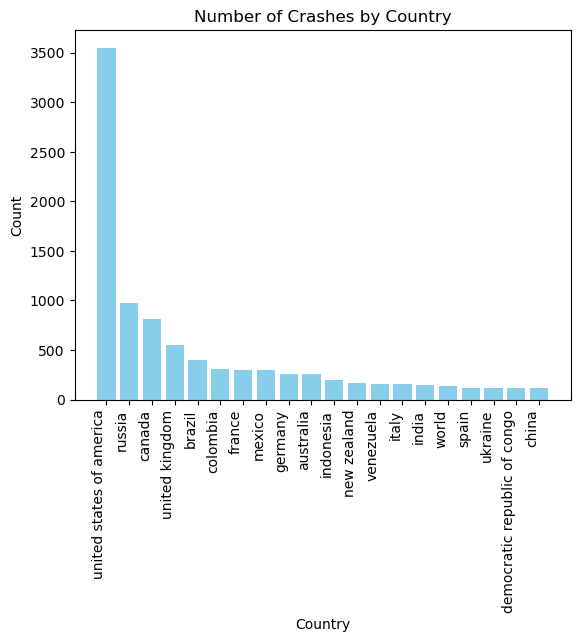

In [206]:
df_cleaned['country'].value_counts().head(20)
import matplotlib.pyplot as plt
top_20_countries = df_cleaned['country'].value_counts().head(20)
plt.bar(top_20_countries.index, top_20_countries.values, color="skyblue")
plt.title("Number of Crashes by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')
plt.show()